In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)
from tensorflow.keras.optimizers import Adam
import random
from functions.displayer import (plot_cycle,
                                 plot_loss,
                                 plot_reconstruction,
                                 plot_mae_per_cycle)
from functions.data_processor import DataProcessor
from models.encoder import LSTMEncoder
from models.decoder import LSTMDecoder
from models.autoencoder import Autoencoder
from functions.reconstruction import (calc_avg_mae_per_cycle)

In [2]:
# PATHs
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'

<h1><center>Unsupervised anomaly detection using LSTM-based autoencoders<br/><br/>- Without windowing -</center></h1>
<h3><center>Multivariate time series - Wafers</center></h3>

-------

## I. Data preparation

#### 1. Data reading

- Read csv files

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

- Extract X and y

In [4]:
# Training set
x_train = train[['id', 'value']]
y_train = train.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])
# Testing set
x_test = test[['id', 'value']]
y_test = test.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])

#### 2. Data description

Data contains a calculated measure based on multiple sensors. This measure is **cyclic** with **152 timestamp per cycle**.

In [5]:
n_train_anomaly = y_train.value_counts()
n_test_anomaly = y_test.value_counts()

In [6]:
print('Train anomaly distribution: ', n_train_anomaly, sep='\n', end='\n\n')
print('Test anomaly distribution: ', n_test_anomaly, sep='\n')

Train anomaly distribution: 
 1    903
-1     97
dtype: int64

Test anomaly distribution: 
 1    5499
-1     665
dtype: int64


#### 3. Data visualization

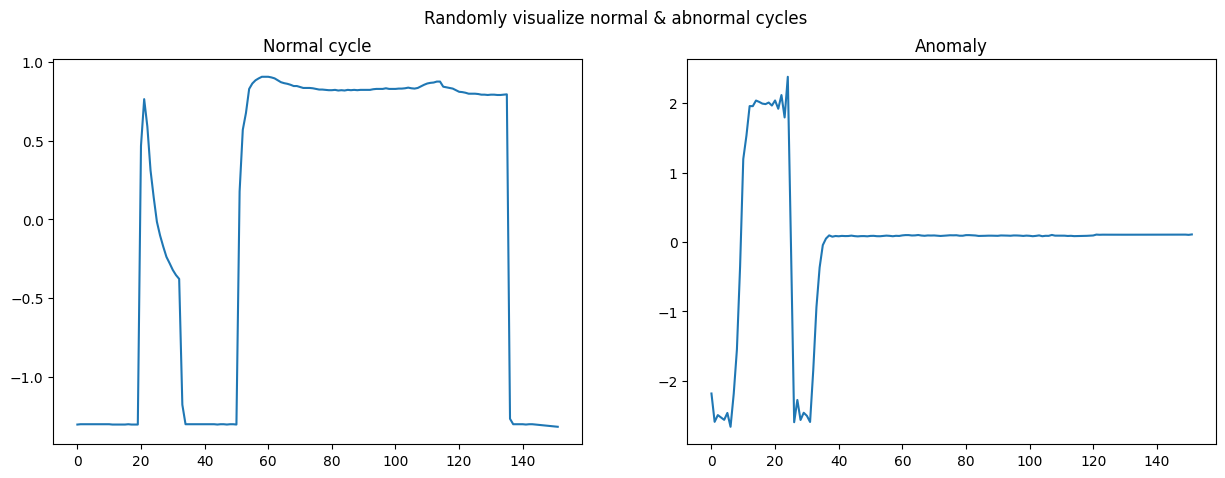

In [7]:
plot_cycle(train)

#### 4. Training set

- The training set for timeseries anomaly detection should be composed exclusively of normal cycles. Since the model's objective is to learn features intrinsic of normal cycles and learn to reconstruct the original series from a small latent space. The error would be higher if the cycle prove to be an anomaly.

In [8]:
x_train = x_train[train.isAnomaly==1].reset_index(drop=True)

#### 5. Data processing 

- Data proccessor parameters

In [9]:
col_names = ['value']
id = 'id'

- Create data processor

In [10]:
dp = DataProcessor(x_train, x_test, col_names, id)

- Scaling data

In [11]:
dp.scale_data()

- Reshaping data

In [12]:
dp.reshape_data()
print(dp.s_train.shape)

(903, 152, 1)


## II. Training an auto-encoder

#### 0. Dimensions definition

In [48]:
# Training set shape
shape = dp.s_train.shape
# Sub sequence shape
length_sequence = shape[1]
n_features = shape[2]
# Latent dimension 
n_latent = 24

#### 1. Create an LSTM encoder

In [49]:
encoder = LSTMEncoder(length_sequence, n_features, n_latent).model

#### 2. Create an LSTM decoder

In [50]:
decoder = LSTMDecoder(length_sequence, n_features, n_latent).model

#### 3. Create an auto-encoder

In [51]:
ae = Autoencoder(encoder, decoder).model

#### 4. Compile and explore the auto-encoder

In [52]:
lr = 0.01  # taux d'apprentissage personnalisé
optimizer = Adam(learning_rate=lr)

In [53]:
ae.compile(optimizer=optimizer, loss='mse')
ae.summary()

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 152, 1)]          0         
                                                                 
 Encoder-Model (Functional)  (None, 24)                13720     
                                                                 
 Decoder-Model (Functional)  (None, 152, 1)            16637     
                                                                 
Total params: 30,357
Trainable params: 30,163
Non-trainable params: 194
_________________________________________________________________


#### 5. Fitting the model

- Training the model

In [54]:
history = ae.fit(x=dp.s_train,
                 y=dp.s_train,
                 batch_size=8,
                 epochs=15,
                 validation_data=(dp.s_test, dp.s_test))

Epoch 1/15
113/113 [==============================] - 40s 303ms/step - loss: 0.3889 - val_loss: 0.6642
Epoch 2/15
113/113 [==============================] - 31s 274ms/step - loss: 0.3259 - val_loss: 0.4840
Epoch 3/15
113/113 [==============================] - 32s 281ms/step - loss: 0.2766 - val_loss: 0.4743
Epoch 4/15
113/113 [==============================] - 34s 299ms/step - loss: 0.2681 - val_loss: 0.3494
Epoch 5/15
113/113 [==============================] - 33s 290ms/step - loss: 0.2737 - val_loss: 0.4990
Epoch 6/15
113/113 [==============================] - 33s 297ms/step - loss: 0.2890 - val_loss: 1.1709
Epoch 7/15
113/113 [==============================] - 36s 319ms/step - loss: 0.3512 - val_loss: 0.3717
Epoch 8/15
113/113 [==============================] - 35s 312ms/step - loss: 0.2767 - val_loss: 0.3535
Epoch 9/15
113/113 [==============================] - 45s 398ms/step - loss: 0.2716 - val_loss: 0.3182
Epoch 10/15
113/113 [==============================] - 49s 432ms/step - l

- Plotting loss functions

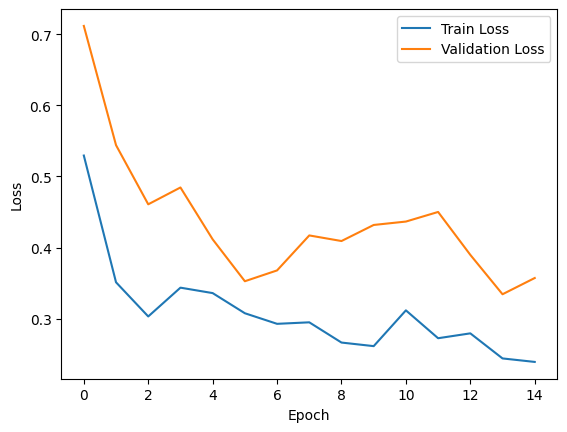

In [30]:
plot_loss(history)

#### 6. Test  windowed prediction

In [31]:
r_pred = ae.predict(dp.s_test)

193/193 [==============================] - 7s 38ms/step


## III. Reconstruction

#### 1. Transform windowed prediction into reconstructed cycles 

- Plotting reconstructed cycle

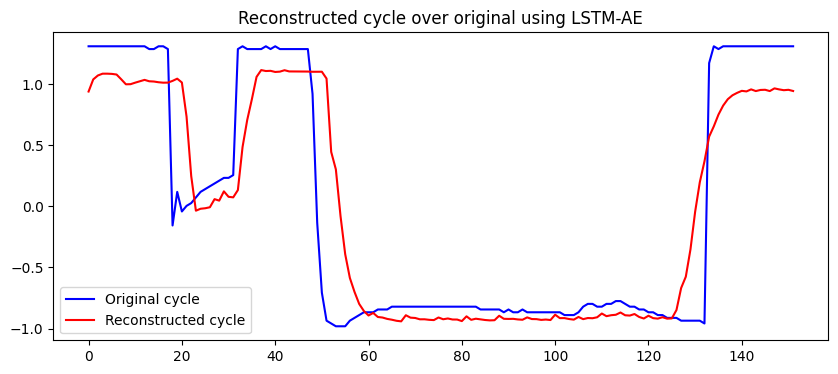

In [57]:
# Normal cycle
y_test_normal = y_test[y_test==1].index.tolist()
cycle = random.choice(y_test_normal)
plot_reconstruction(dp.s_test, r_pred, cycle)

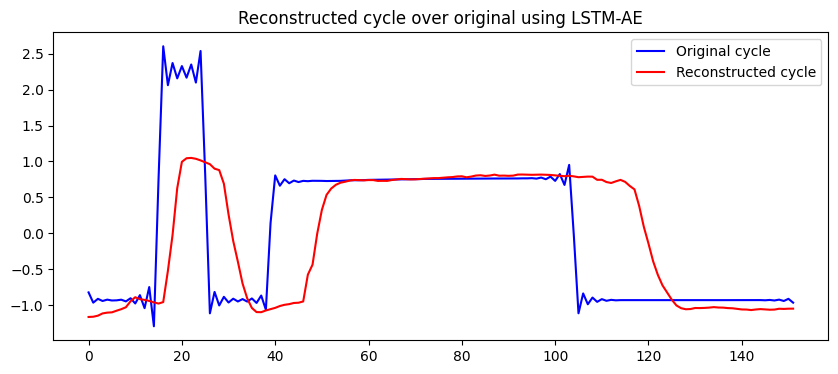

In [58]:
# Anomaly
y_test_anomaly = y_test[y_test==-1].index.tolist()
cycle = random.choice(y_test_anomaly)
plot_reconstruction(dp.s_test, r_pred, cycle)

#### 2. Average reconstruction error per cycle

- Calculate the average mean absolute error (MAE) per cycle between a set of original 3D sequences and their reconstructions.

In [34]:
mae_per_cycle = calc_avg_mae_per_cycle(dp.s_test, r_pred)

- Plotting the average reconstruction error per cycle

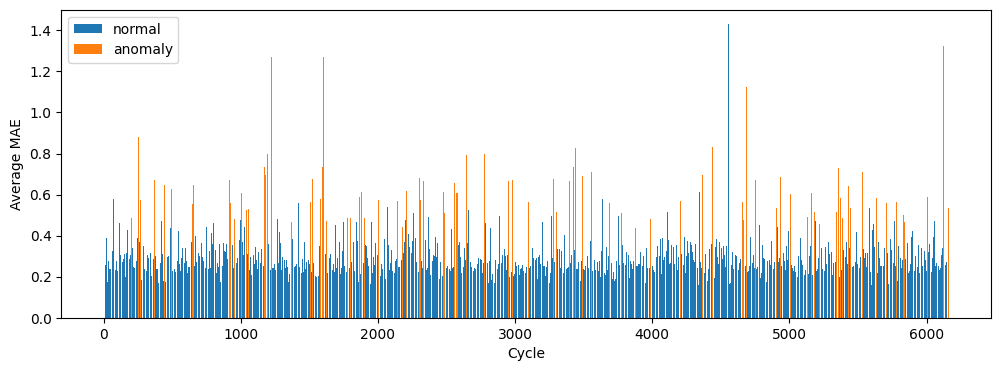

In [35]:
plot_mae_per_cycle(mae_per_cycle, y_test)

#### 3. Anomaly detection using a threshold on MAE per cycle

In [44]:
threshold = 0.5

In [45]:
y_pred = [1 if x<threshold else -1 for x in mae_per_cycle]

#### 4. Evaluation of anomaly detection using a threshold

In [46]:
accuracy = accuracy_score(y_test, y_pred)
confusion_m = confusion_matrix(y_test, y_pred)
cf_report = classification_report(y_test, y_pred)

In [47]:
print('Accuracy: %.2f' % accuracy, end='\n\n')
print('Confusion matrix: \n', confusion_m, end='\n\n')
print('Classification report: \n\n', cf_report)

Accuracy: 0.97

Confusion matrix: 
 [[ 569   96]
 [  90 5409]]

Classification report: 

               precision    recall  f1-score   support

          -1       0.86      0.86      0.86       665
           1       0.98      0.98      0.98      5499

    accuracy                           0.97      6164
   macro avg       0.92      0.92      0.92      6164
weighted avg       0.97      0.97      0.97      6164

